In [13]:
# "The social benefits of emotion variability"
# Analysis script for Studies 3a-3b 
# Evan W. Carr, 05-01-2018 (Columbia Business School)

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

from plotnine import *
from rpy2.robjects import r, pandas2ri

%matplotlib inline

# Prior to this analysis, subjects that didn't finish the study were excluded/removed from the data files...
# Set working directory to location of data files, and read in .csv's:
rawData3a = pd.read_csv("manic5_cleanData_combinedAnalysis.csv")
rawData3b = pd.read_csv("manic6_cleanData_combinedAnalysis.csv").drop(['condition'], axis=1)

rawData3a['subject'] = rawData3a['subject'].astype(str)
rawData3b['subject'] = rawData3b['subject'].astype(str)

# Make unique IDs by study (to avoid combining the same ID across studies):
rawData3a['subject'] = rawData3a['subject'] + '_3a'
rawData3b['subject'] = rawData3b['subject'] + '_3b'

In [11]:
# Quickly check subject times to complete the study (usually around 11-13 minutes for Study 3a; 5-7 minutes for Study 3b):
completionTimes3a = rawData3a.groupby('subject').agg({'latency': 'sum'}).reset_index()
completionTimes3a['latency_mins'] = (completionTimes3a['latency'] / 1000) / 60
completionTimes3a.head(10)

,subject,latency,latency_mins
0,100883231_3a,816746,13.612433
1,10116481_3a,668488,11.141467
2,115128849_3a,839380,13.989667
3,11596006_3a,736135,12.268917
4,117836360_3a,989331,16.488850
5,11784308_3a,1044310,17.405167
6,123417569_3a,396323,6.605383
7,130414932_3a,625271,10.421183
8,132576606_3a,701885,11.698083
9,148509182_3a,608667,10.144450


In [12]:
completionTimes3b = rawData3b.groupby('subject').agg({'latency': 'sum'}).reset_index()
completionTimes3b['latency_mins'] = (completionTimes3b['latency'] / 1000) / 60
completionTimes3b.head(10)

,subject,latency,latency_mins
0,100779565_3b,309710,5.161833
1,102374703_3b,368547,6.142450
2,110337523_3b,395024,6.583733
3,110504542_3b,499767,8.329450
4,110750170_3b,440970,7.349500
5,113256336_3b,305443,5.090717
6,116115107_3b,454236,7.570600
7,117376550_3b,287587,4.793117
8,118358767_3b,474915,7.915250
9,123473946_3b,526936,8.782267


In [16]:
# Combine datasets and preview:
rawData = pd.concat([rawData3a, rawData3b], axis=0)

# Remove unnecessary columns, and filter only to important rows (when subjects gave ratings):
sliderList = ['authenticity_slider', 'power_slider', 'trust_slider', 'happiness_slider', 'leadership_slider', 'teammember_slider']

cleanData = rawData.drop(['trialnum', 'blockcode', 'correct', 'latency', 'stimulusitem1'], axis=1)
cleanRatings = cleanData.loc[cleanData['trialcode'].isin(sliderList), :].sort_values(by=['subject', 'blocknum'])
cleanRatings.head(20)

,subject,blocknum,trialcode,response,model_block_variability,model_block_valence,model_block_gender,model_id
54231,100779565_3b,2,teammember_slider,55,high,neutral,female,WF-009
54232,100779565_3b,2,leadership_slider,25,high,neutral,female,WF-009
54233,100779565_3b,2,happiness_slider,60,high,neutral,female,WF-009
54254,100779565_3b,3,leadership_slider,16,low,negative,male,WM-029
54255,100779565_3b,3,teammember_slider,25,low,negative,male,WM-029
54256,100779565_3b,3,happiness_slider,7,low,negative,male,WM-029
54277,100779565_3b,4,happiness_slider,93,low,positive,female,WF-011
54278,100779565_3b,4,teammember_slider,83,low,positive,female,WF-011
54279,100779565_3b,4,leadership_slider,88,low,positive,female,WF-011
54300,100779565_3b,5,leadership_slider,2,high,negative,male,WM-016


In [17]:
# Create individual datasets for each major DV:
authenticityData = cleanRatings.query("trialcode == 'authenticity_slider'")
powerData = cleanRatings.query("trialcode == 'power_slider'")
trustData = cleanRatings.query("trialcode == 'trust_slider'")
happinessData = cleanRatings.query("trialcode == 'happiness_slider'")
leadershipData = cleanRatings.query("trialcode == 'leadership_slider'")
teamData = cleanRatings.query("trialcode == 'teammember_slider'")

In [18]:
# Run mixed-effects models on each DV:
#    - fixed = variability (high vs. low) & valence (negative vs. neutral vs. positive)
#    - random = subject & model_id

# Push objects to R to start analyses ...
# (statsmodels package in python has trouble fitting certain random-effect structures):

pandas2ri.activate()
%load_ext rpy2.ipython

In [19]:
# Send datasets with ratings to R: 
%R -i authenticityData,powerData,trustData,happinessData,leadershipData,teamData

In [20]:
%%R

# Use R to create mixed-effects models with both subject- and stimulus-level random effects:

library(lmerTest)

a_m2 <- lmer(response ~ model_block_valence * model_block_variability + (1|subject) + (1|model_id), data=authenticityData)
a_m2_anova <- anova(a_m2)
a_m2_lsmeans <- lsmeans(a_m2)
             
p_m2 <- lmer(response ~ model_block_valence * model_block_variability + (1|subject) + (1|model_id), data=powerData)
p_m2_anova <- anova(p_m2)
p_m2_lsmeans <- lsmeans(p_m2)
                          
t_m2 <- lmer(response ~ model_block_valence * model_block_variability + (1|subject) + (1|model_id), data=trustData)
t_m2_anova <- anova(t_m2)
t_m2_lsmeans <- lsmeans(t_m2)
                                       
h_m2 <- lmer(response ~ model_block_valence * model_block_variability + (1|subject) + (1|model_id), data=happinessData)
h_m2_anova <- anova(h_m2)
h_m2_lsmeans <- lsmeans(h_m2)

lead_m2 <- lmer(response ~ model_block_valence * model_block_variability + (1|subject) + (1|model_id), data=leadershipData)
lead_m2_anova <- anova(lead_m2)
lead_m2_lsmeans <- lsmeans(lead_m2)

team_m2 <- lmer(response ~ model_block_valence * model_block_variability + (1|subject) + (1|model_id), data=teamData)
team_m2_anova <- anova(team_m2)
team_m2_lsmeans <- lsmeans(team_m2)

In [21]:
# Pull model results back to python:
%R -o a_m2_anova,a_m2_lsmeans,p_m2_anova,p_m2_lsmeans,t_m2_anova,t_m2_lsmeans,h_m2_anova,h_m2_lsmeans
%R -o lead_m2_anova,lead_m2_lsmeans,team_m2_anova,team_m2_lsmeans

In [22]:
# On authenticity, all effects are significant:
pandas2ri.ri2py(a_m2_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block_valence,110873.488497,55436.744249,2,3153.876642,135.023199,0.000000e+00
model_block_variability,18732.021431,18732.021431,1,3154.797995,45.624206,1.698908e-11
model_block_valence:model_block_variability,2570.673823,1285.336911,2,3154.530710,3.130601,4.382732e-02


In [23]:
# For power ratings, both main effects significant & interaction trending:
pandas2ri.ri2py(p_m2_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block_valence,29834.644226,14917.322113,2,3032.587068,40.775501,0.000000
model_block_variability,3933.232775,3933.232775,1,3032.465915,10.751228,0.001054
model_block_valence:model_block_variability,1863.654963,931.827481,2,3032.410765,2.547088,0.078477


In [24]:
# With trust, both main effects significant, but no interaction: 
pandas2ri.ri2py(t_m2_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block_valence,220509.282513,110254.641256,2,2889.196954,315.766760,0.000000
model_block_variability,7239.031282,7239.031282,1,2889.049773,20.732419,0.000005
model_block_valence:model_block_variability,709.972374,354.986187,2,2888.687221,1.016672,0.361926


In [25]:
# All effects significant for happiness ratings:
pandas2ri.ri2py(h_m2_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block_valence,715363.191390,357681.595695,2,3020.741827,960.173941,0.000000
model_block_variability,27658.761955,27658.761955,1,3021.410386,74.248222,0.000000
model_block_valence:model_block_variability,6379.108325,3189.554163,2,3021.485056,8.562159,0.000196


In [28]:
# On leadership ratings, all effects significant (similar to authenticity and happiness):
pandas2ri.ri2py(lead_m2_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block_valence,335867.680386,167933.840193,2,5572.788863,399.597577,0.000000
model_block_variability,4991.910400,4991.910400,1,5573.159120,11.878221,0.000572
model_block_valence:model_block_variability,9831.026659,4915.513330,2,5573.198901,11.696435,0.000009


In [30]:
# Team member ratings show both main effects, but no interaction (similar to trust ratings):
pandas2ri.ri2py(team_m2_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block_valence,839702.190445,419851.095222,2,5572.531043,936.126877,0.000000
model_block_variability,8821.872403,8821.872403,1,5572.805214,19.669811,0.000009
model_block_valence:model_block_variability,1309.756345,654.878172,2,5572.834780,1.460158,0.232288


In [34]:
# Prep lists of estimates and SEM's for plot dataframe:
estimateList1 = [pandas2ri.ri2py(a_m2_lsmeans[0]).Estimate[5:11],
                pandas2ri.ri2py(t_m2_lsmeans[0]).Estimate[5:11],
                pandas2ri.ri2py(p_m2_lsmeans[0]).Estimate[5:11],
                pandas2ri.ri2py(h_m2_lsmeans[0]).Estimate[5:11],
                pandas2ri.ri2py(lead_m2_lsmeans[0]).Estimate[5:11],
                pandas2ri.ri2py(team_m2_lsmeans[0]).Estimate[5:11]]
estimateList2 = []

semList1 = [pandas2ri.ri2py(a_m2_lsmeans[0])['Standard Error'][5:11],
            pandas2ri.ri2py(t_m2_lsmeans[0])['Standard Error'][5:11],
            pandas2ri.ri2py(p_m2_lsmeans[0])['Standard Error'][5:11],
            pandas2ri.ri2py(h_m2_lsmeans[0])['Standard Error'][5:11],
            pandas2ri.ri2py(lead_m2_lsmeans[0])['Standard Error'][5:11],
            pandas2ri.ri2py(team_m2_lsmeans[0])['Standard Error'][5:11]]
semList2 = []

for sublist in estimateList1:
    for item in sublist:
        estimateList2.append(item)
        
for sublist in semList1:
    for item in sublist:
        semList2.append(item)

In [36]:
# Create dataset for plotting:
plotData = pd.DataFrame({
    'rating_type': ['Authenticity']*6 + ['Trust']*6 + ['Power']*6 + ['Happiness']*6 + ['Leadership']*6 + ['Team Member']*6,
    'valence': ['Negative', 'Neutral', 'Positive']*12,
    'variability': ['High Variability', 'High Variability', 'High Variability',
                    'Low Variability', 'Low Variability', 'Low Variability']*6, 
    'slider_mean': estimateList2,
    'slider_sem': semList2
})

plotData

,rating_type,slider_mean,slider_sem,valence,variability
0,Authenticity,53.2790,1.4476,Negative,High Variability
1,Authenticity,60.8728,1.4476,Neutral,High Variability
2,Authenticity,68.2478,1.4475,Positive,High Variability
3,Authenticity,50.8040,1.4476,Negative,Low Variability
4,Authenticity,54.1758,1.4476,Neutral,Low Variability
5,Authenticity,63.4210,1.4477,Positive,Low Variability
6,Trust,47.3731,1.7412,Negative,High Variability
7,Trust,58.8622,1.7412,Neutral,High Variability
8,Trust,67.1837,1.7407,Positive,High Variability
9,Trust,44.2571,1.7412,Negative,Low Variability


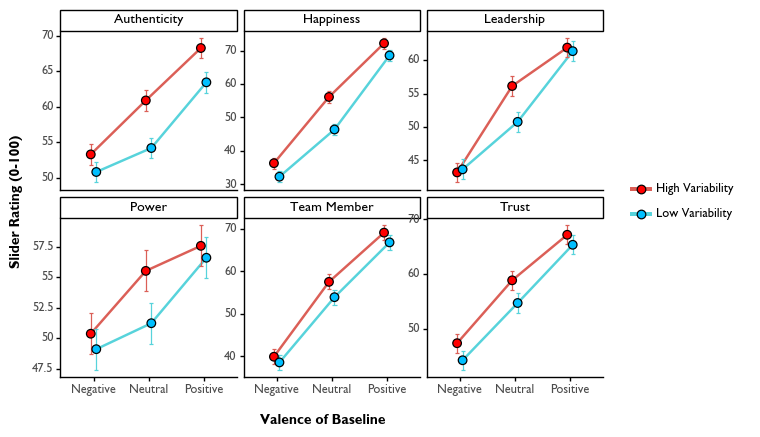

<ggplot: (-9223371907016528703)>

In [39]:
# Use plotnine package to plot using ggplot2 (R) style ...
(ggplot(plotData, aes(x='valence', y='slider_mean', fill='variability', group='variability', color='variability'))
 + geom_line(size=1, position=position_dodge(0.2))
 + geom_errorbar(aes(ymin='slider_mean-slider_sem', ymax='slider_mean+slider_sem', color='variability'), width=0.15, position=position_dodge(0.2))
 + geom_point(shape='o', color='black', size=3, stroke=0.5, position=position_dodge(0.2), alpha=1)
 + scale_fill_manual(values=["red", "deepskyblue"])
 + facet_wrap('~rating_type', scales='free_y', nrow=2, ncol=3)
 + labs(y='Slider Rating (0-100)\n', x='\nValence of Baseline') 
 + theme_classic()
 + theme(figure_size = (7, 4.5),
         text = element_text(family='Gill Sans MT'), 
         axis_text_x = element_text(size=9), 
         axis_text_y = element_text(size=9), 
         axis_title_x = element_text(weight='bold', size=10), 
         axis_title_y = element_text(weight='bold', size=10),
         axis_line_y = element_line(color='black'),
         legend_title = element_blank(),
         legend_text = element_text(size=9),
         legend_position = 'right',
         strip_background = element_rect(fill='white'),
         strip_text_x = element_text(size=10, color='black'))) 
  